In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

In [2]:
sys.path.append("../modules/")

In [3]:
import ContentRecommender
import CollaborativeRecommender

In [4]:
import UserStreamViews
import CombinedRecommender

In [5]:
user_views_per_stream_df = pd.read_csv("data/user_views_per_stream.csv", header=0)
user_views_per_stream_df.head()

,USERID,STREAMID,num_views,day_of_week,time_labeled,num_cards,views_per_card
0,245,163,1029,Wednesday,Afternoon,15,68.600000
1,245,167,258,Thursday,Afternoon,14,18.428571
2,245,171,123,Wednesday,Afternoon,6,20.500000
3,245,172,83,Wednesday,Afternoon,4,20.750000
4,245,173,167,Monday,Afternoon,8,20.875000


In [6]:
unique_users = np.unique(user_views_per_stream_df["USERID"].values)
unique_users.shape

(219,)

In [7]:
stream_views_raw_df = pd.read_csv("data/content_views_raw.csv", header=0)
stream_views_raw_df.head()

,USERID,CARDID,CARDTITLE,STREAMID,STREAMNAME,TIMESTAMP,MODULEID,MODULENAME
0,1007,2798,QUICK TEST - WHAT IS IN MY ENGINE OIL?,561,What is engine oil made of?,31-05-2017 01:14,430,2. WHAT IS ENGINE OIL MADE OF?
1,1007,2798,QUICK TEST - WHAT IS IN MY ENGINE OIL?,561,What is engine oil made of?,31-05-2017 01:14,430,2. WHAT IS ENGINE OIL MADE OF?
2,1007,2798,QUICK TEST - WHAT IS IN MY ENGINE OIL?,561,What is engine oil made of?,31-05-2017 01:14,430,2. WHAT IS ENGINE OIL MADE OF?
3,1007,2808,ENGINE OIL ADDITIVES,561,What is engine oil made of?,31-05-2017 01:15,430,2. WHAT IS ENGINE OIL MADE OF?
4,1007,2808,ENGINE OIL ADDITIVES,561,What is engine oil made of?,31-05-2017 01:15,430,2. WHAT IS ENGINE OIL MADE OF?


In [8]:
stream_views_raw_df['TIMESTAMP'] = pd.to_datetime(stream_views_raw_df['TIMESTAMP'], format="%d-%m-%Y %H:%M")


In [9]:
NUM_USERS = 10
selected_users = np.random.choice(unique_users, NUM_USERS, False)


## Content recommendations for each of the users

In [ ]:
content_recommended_streams = []
all_user_viewed_streams = []

for userid in selected_users:
    recent_viewed_streams = UserStreamViews.get_latest_streams_for_user(stream_views_raw_df, userid)
    recent_viewed_stream_ids = [x[0] for x in recent_viewed_streams]
    similar_streams_based_on_history = ContentRecommender.get_similar_streams_based_on_history(recent_viewed_stream_ids)
    if similar_streams_based_on_history is not None:
        recommended_stream_ids = [s[0] for s in similar_streams_based_on_history]
        content_recommended_streams.extend(recommended_stream_ids)
    
    current_user_viewed_streams = user_views_per_stream_df[user_views_per_stream_df["USERID"] == userid]["STREAMID"].values
    all_user_viewed_streams.extend(current_user_viewed_streams)
    
content_recommended_streams = set(content_recommended_streams)
all_user_viewed_streams = set(all_user_viewed_streams)

print("Recommendations")
print(content_recommended_streams)
print(all_user_viewed_streams)

recommended_content_viewed = content_recommended_streams.intersection(all_user_viewed_streams)
len(recommended_content_viewed) / len(content_recommended_streams)

In [ ]:
def get_content_recommendation_performance(users, num_recommendations = 10):
    content_recommended_streams = []
    all_user_viewed_streams = []

    for userid in users:
        recent_viewed_streams = UserStreamViews.get_latest_streams_for_user(stream_views_raw_df, userid)
        recent_viewed_stream_ids = [x[0] for x in recent_viewed_streams]
        similar_streams_based_on_history = ContentRecommender.get_similar_streams_based_on_history(recent_viewed_stream_ids, max_similar_streams = num_recommendations)
        if similar_streams_based_on_history is not None:
            recommended_stream_ids = [s[0] for s in similar_streams_based_on_history]
            content_recommended_streams.extend(recommended_stream_ids)

        current_user_viewed_streams = user_views_per_stream_df[user_views_per_stream_df["USERID"] == userid]["STREAMID"].values
        all_user_viewed_streams.extend(current_user_viewed_streams)
    
    content_recommended_streams = set(content_recommended_streams)
    all_user_viewed_streams = set(all_user_viewed_streams)

    print("Recommendations")
    #print(content_recommended_streams)
    #print(all_user_viewed_streams)

    recommended_content_viewed = content_recommended_streams.intersection(all_user_viewed_streams)
    recommended_content_viewed_ratio = len(recommended_content_viewed) / len(content_recommended_streams)
    return recommended_content_viewed_ratio

In [ ]:
content_reco_perfs = []
for itr in [10, 15, 20, 25, 30]:
    content_reco_perf = 0
    for jtr in range(10):
        selected_users = np.random.choice(unique_users, 20, False)
        content_reco_perf += get_content_recommendation_performance(selected_users, itr)
        
    content_reco_perfs.append((itr, content_reco_perf/10))

In [ ]:
content_reco_perfs

In [ ]:
x = [content_reco_perf[0] for content_reco_perf in content_reco_perfs if content_reco_perf[0] != 15]
y = [content_reco_perf[1] for content_reco_perf in content_reco_perfs if content_reco_perf[0] != 15]

plt.plot(x, y)

## Collaborative recommendations for the users

In [ ]:
def get_collaborative_recommendation_performance(users, num_recommendations = 10):
    collaborative_recommended_streams = []
    all_user_viewed_streams = []

    for userid in users:
        streams_based_on_other_users = CollaborativeRecommender.get_similar_streams_based_on_other_users(userid, max_similar_streams = num_recommendations)
        # print(streams_based_on_other_users)
        if streams_based_on_other_users is not None:
            recommended_stream_ids = [int(s[0]) for s in streams_based_on_other_users]
            collaborative_recommended_streams.extend(recommended_stream_ids)

        current_user_viewed_streams = user_views_per_stream_df[user_views_per_stream_df["USERID"] == userid]["STREAMID"].values
        all_user_viewed_streams.extend(current_user_viewed_streams)
    
    collaborative_recommended_streams = set(collaborative_recommended_streams)
    all_user_viewed_streams = set(all_user_viewed_streams)

    # print("Recommendations")
    #print(content_recommended_streams)
    #print(all_user_viewed_streams)

    recommended_content_viewed = collaborative_recommended_streams.intersection(all_user_viewed_streams)
    recommended_content_viewed_ratio = len(recommended_content_viewed) / len(collaborative_recommended_streams)
    return recommended_content_viewed_ratio

In [ ]:
collaborative_reco_perfs = []
for itr in [10, 15, 20, 25, 30]:
    collaborative_reco_perf = 0
    for jtr in range(10):
        selected_users = np.random.choice(unique_users, 20, False)
        collaborative_reco_perf += get_collaborative_recommendation_performance(selected_users, itr)
        
    collaborative_reco_perfs.append((itr, collaborative_reco_perf/10))

In [ ]:
collaborative_reco_perfs

In [ ]:
x = [collaborative_reco_perf[0] for collaborative_reco_perf in collaborative_reco_perfs]
y = [collaborative_reco_perf[1] for collaborative_reco_perf in collaborative_reco_perfs]

plt.plot(x, y)

In [ ]:
get_collaborative_recommendation_performance([1007], 30)

## Hybrid recommender performance

In [10]:
def get_hybrid_recommendation_performance(users, num_recommendations = 10):
    hybrid_recommended_streams = []
    all_user_viewed_streams = []

    for userid in users:
        recent_viewed_streams = UserStreamViews.get_latest_streams_for_user(stream_views_raw_df, userid)
        recent_viewed_stream_ids = [x[0] for x in recent_viewed_streams]
        recommended_stream_ids, selection_reasoning = CombinedRecommender.get_recommended_stream_ids(userid, recent_viewed_stream_ids, max_num_streams_required = num_recommendations)
        
        if recommended_stream_ids is not None:
            recommended_stream_ids = [int(s[0]) for s in recommended_stream_ids]
            hybrid_recommended_streams.extend(recommended_stream_ids)

        current_user_viewed_streams = user_views_per_stream_df[user_views_per_stream_df["USERID"] == userid]["STREAMID"].values
        all_user_viewed_streams.extend(current_user_viewed_streams)
    
    hybrid_recommended_streams = set(hybrid_recommended_streams)
    all_user_viewed_streams = set(all_user_viewed_streams)

    # print("Recommendations")
    #print(content_recommended_streams)
    #print(all_user_viewed_streams)

    recommended_content_viewed = hybrid_recommended_streams.intersection(all_user_viewed_streams)
    recommended_content_viewed_ratio = len(recommended_content_viewed) / len(hybrid_recommended_streams)
    return recommended_content_viewed_ratio

In [11]:
hybrid_reco_perfs = []
for itr in [10, 15, 20, 25, 30]:
    hybrid_reco_perf = 0
    for jtr in range(10):
        selected_users = np.random.choice(unique_users, 20, False)
        hybrid_reco_perf += get_hybrid_recommendation_performance(selected_users, itr)
        
    hybrid_reco_perfs.append((itr, hybrid_reco_perf/10))

In [12]:
hybrid_reco_perfs

[(10, 0.6586557505005429),
 (15, 0.6251491357924899),
 (20, 0.6016517555021279),
 (25, 0.6020060859488241),
 (30, 0.6132230022216829)]

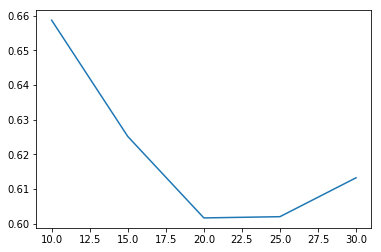

In [13]:
x = [hybrid_reco_perf[0] for hybrid_reco_perf in hybrid_reco_perfs]
y = [hybrid_reco_perf[1] for hybrid_reco_perf in hybrid_reco_perfs]

plt.plot(x, y)